In [1]:
import numpy as np
import pandas as pd
import lightning as L
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from helpers_convolutional_filters import compute_num_conv_features, init_conv_layers
from Convolutional_Mormyromast import ConvMormyromast
from lfp_response_dataset import LfpResponseDataset, create_train_and_validation_datasets

data_fname = "../data/lfp-abby/processed/single_trials.pkl"
data_fname_averages = "../data/lfp-abby/processed/trial_averages.pkl"
data = pd.read_pickle(data_fname)
data_averages = pd.read_pickle(data_fname_averages)

print(f"Loaded data shape: single trials - {data.shape}, trial averages - {data_averages.shape}")

Loaded data shape: single trials - (34593, 29), trial averages - (2676, 31)


In [3]:
train_dataset, valid_dataset = create_train_and_validation_datasets(
    data, fish_id="fish_01", zone="mz", percent_train=0.8
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=15, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=15, persistent_workers=True)

model = ConvMormyromast(
    input_length=next(iter(train_loader))[0].shape[2],
    input_channels=1,
    conv_layer_fraction_widths=[1],
    conv_output_channels=1,
    conv_stride=25,
    N_receptors=1,
)

In [4]:
learning_rate = 0.001
input_noise_std = 0.4

# define the LightningModule
class LitModel(L.LightningModule):
    def __init__(self, model, input_noise_std=input_noise_std):
        super().__init__()
        self.model = model
        self.input_noise_std = input_noise_std

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x += torch.randn(*x.shape).to(x.device) * self.input_noise_std
        y_hat = self.model(x)
        loss = nn.functional.mse_loss(y_hat, y)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        y_hat = self.model(x)
        val_loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", val_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

lit_model = LitModel(model)

In [ ]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

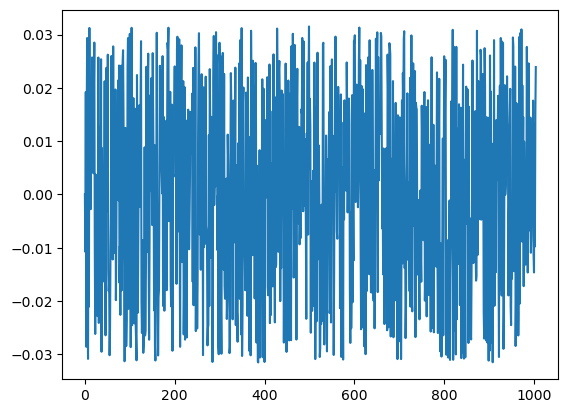

In [5]:
plt.plot(lit_model.model.conv_list[0].weight.detach().squeeze().numpy())
plt.show()

In [6]:
checkpoint = "./lightning_logs/version_0/checkpoints/epoch=99-step=7800.ckpt"
autoencoder = LitModel.load_from_checkpoint(checkpoint, model=model)

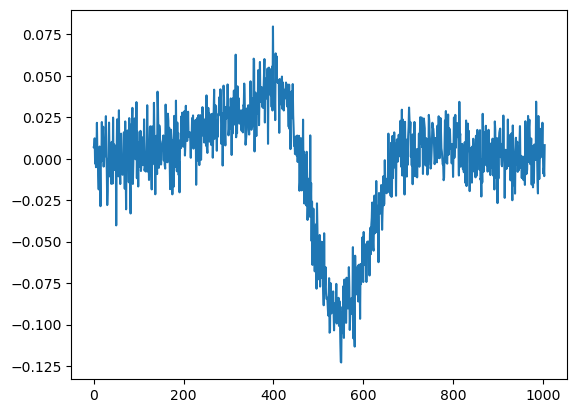

In [8]:
plt.plot(lit_model.model.conv_list[0].weight.detach().cpu().squeeze().numpy())
plt.show()